## Imports


In [4]:
!pip install beautifulsoup4 --quiet
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.7 MB/s eta 0:00:00


In [5]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

## Data Extraction

### Scraping

#### https://chatgptprompts.co/

In [6]:
# Send a GET request to the website
url = "https://chatgptprompts.co/"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")
data = soup.find("a", href="writers").get_text()


In [7]:
all_prompts={}
elements = soup.find_all("a")

for element in elements:
    href = element.get("href")
    try:
      link = url + href
      link_response = requests.get(link)
      link_soup = BeautifulSoup(link_response.text, "html.parser")
      all_object=link_soup.find_all("li")
      if len(all_object)!=0:
        category_prompt = element.get("href")
        all_prompts[category_prompt] =[]
        for object_ in all_object:
          all_prompts[category_prompt].append(object_.get_text())
    except :
      continue


In [8]:

transformed_data = []
for category_prompt, texts in all_prompts.items():
    for text in texts:
        transformed_data.append({"category_prompt": category_prompt, "text": text})

df = pd.DataFrame(transformed_data)


In [9]:
dict_sample = {}
for tup in df.itertuples():
  if not tup[1] in dict_sample.keys():
    dict_sample[tup[1]] = tup[2]

dict_sample

{'writers': 'Write about a character who wakes up in a different body every day.',
 'developers': '“Write a tutorial on how to use Chat GPT to generate code snippets.”',
 'seo': 'Develop a comprehensive guide to technical SEO for travel content, including how to effectively use schema markup and structured data.',
 'social-media': '“I’m having trouble identifying my target audience on social media. Can you help me with audience research and suggest ways to reach my target audience?”',
 'accountants': 'How can small business owners use accounting to track expenses and increase profitability?',
 'college-students': '“How can Chat GPT assist in finding credible sources for research papers?”',
 'game-developers': 'What are some best practices for game development that can help ensure a high-quality end product?',
 'programmers': 'Implement a text-based adventure game in Python where the player navigates through different rooms and interacts with objects to solve puzzles and progress throug

In [10]:
df.head()

,category_prompt,text
0,writers,Write about a character who wakes up in a diff...
1,writers,"Write a story that begins with the sentence, “..."
2,writers,Write about a character who discovers they hav...
3,writers,Write a story from the perspective of an objec...
4,writers,Write about a world where dreams become reality.


In [11]:
df['category_prompt'].unique()

array(['writers', 'developers', 'seo', 'social-media', 'accountants',
       'college-students', 'game-developers', 'programmers', 'Marketers',
       'Amazon-Sellers', 'Product-Managers', 'Internet-Marketers',
       'Business', 'Customer-Service', 'Lawyers', 'IT-Professionals',
       'Web-Developers', 'Engineers', 'Architects',
       'health-professionals', 'Teachers-Educators', 'Travel-Agents',
       'Graphic-Designers', 'Data-Scientists', 'journalists',
       'scientists', 'social-workers', 'Librarians', 'Politicians',
       'Food-Service-Professionals', 'Fitness-Trainers',
       'Sports-Analysts', 'Photographers-and-videographers',
       'Event Planners', 'Real-Estate-Agents',
       'Psychologists-and-Therapists'], dtype=object)

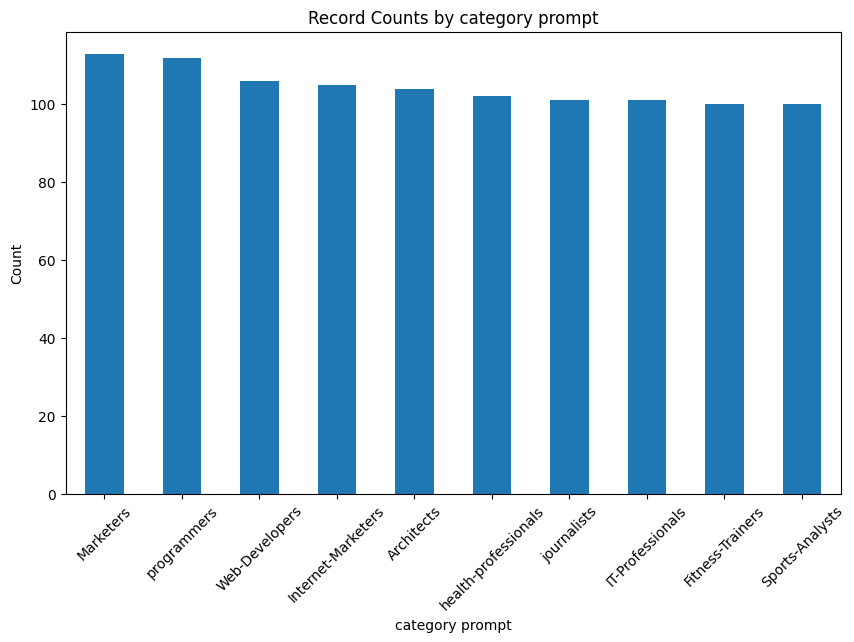

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df' and the category column is named 'category'
category_counts = df['category_prompt'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Record Counts by category prompt')
plt.xlabel('category prompt')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

From each category I have an average of 100 prompts.

## Tranformers
The idea is to fine-tune the model so that the prompt vectors are more accurate.

In [13]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00


### Training phase

In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer

# Step 1: Loading a classic BERT model with a classification layer of the size you decide
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, pooled=False):
        outputs = self.bert(input_ids, attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.fc(pooled_output)
        if pooled:
          return outputs, pooled_output
        return logits

In [15]:
# Load the pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [16]:
from sklearn.utils import shuffle

# Step 2: Splitting the dataframe into train, validation, and test sets based on category frequencies
train_ratio = 0.8
val_ratio = 0.2
# test_ratio = 0.1

# Calculate the number of records to allocate for each set
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)
# test_size = int(len(df) * test_ratio)

# Group the dataframe by category and count the occurrences
category_counts = df.groupby('category_prompt').size()

# Calculate the number of records for each category in each set
train_category_counts = (category_counts * train_ratio).astype(int)
val_category_counts = (category_counts * val_ratio).astype(int)
# test_category_counts = category_counts - train_category_counts - val_category_counts

# Split the dataframe based on the calculated category counts
train_df = pd.DataFrame()
val_df = pd.DataFrame()
# test_df = pd.DataFrame()

for category in df['category_prompt'].unique():
    category_df = df[df['category_prompt'] == category]

    train_category_df, val_category_df = train_test_split(category_df, train_size=train_category_counts[category], random_state=42)
    # val_category_df, test_category_df = train_test_split(remaining_category_df, train_size=val_category_counts[category], random_state=42)

    train_df = pd.concat([train_df,train_category_df], axis=0)
    val_df = pd.concat([val_df,val_category_df], axis=0)
    # test_df = pd.concat([test_df,test_category_df], axis=0)

train_df = shuffle(train_df)

In [17]:
category_to_number = {category: number for number, category in enumerate(df['category_prompt'].unique())}

In [18]:
# Step 3: Training the BERT model on the train set while checking the loss on the validation and train sets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(df['category_prompt'].unique())

# Instantiate the BERT classifier model
model = BERTClassifier(bert_model, num_classes)
model.to(device)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Function to tokenize and encode the text
def tokenize_text(text):
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt')
    return tokens

In [19]:
# Training loop
epochs = 5
batch_size = 16

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0

    for i in range(0, len(train_df), batch_size):
        batch = train_df[i:i+batch_size]

        inputs = [tokenize_text(text) for text in batch['text']]
        labels = torch.tensor([category_to_number[cat] for cat in batch['category_prompt']])

        input_ids = torch.cat([input['input_ids'] for input in inputs], dim=0).to(device)
        attention_mask = torch.cat([input['attention_mask'] for input in inputs], dim=0).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_df)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]

            inputs = [tokenize_text(text) for text in batch['text']]
            labels = torch.tensor([category_to_number[cat] for cat in batch['category_prompt']])

            input_ids = torch.cat([input['input_ids'] for input in inputs], dim=0).to(device)
            attention_mask = torch.cat([input['attention_mask'] for input in inputs], dim=0).to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_df)

    print(f"Epoch {epoch + 1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_correct / len(train_df):.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_correct / len(val_df):.4f}")

Epoch 1/5: Train Loss: 0.1758, Train Accuracy: 0.3717, Val Loss: 0.1122, Val Accuracy: 0.7909
Epoch 2/5: Train Loss: 0.0757, Train Accuracy: 0.8807, Val Loss: 0.0422, Val Accuracy: 0.9243
Epoch 3/5: Train Loss: 0.0304, Train Accuracy: 0.9584, Val Loss: 0.0201, Val Accuracy: 0.9477
Epoch 4/5: Train Loss: 0.0142, Train Accuracy: 0.9844, Val Loss: 0.0141, Val Accuracy: 0.9519
Epoch 5/5: Train Loss: 0.0076, Train Accuracy: 0.9924, Val Loss: 0.0104, Val Accuracy: 0.9670


#### Save Bert model

In [20]:
from transformers import BertModel

# Assuming you have a trained BERT model named 'bert_model'
save_path = 'bert_classifier.pt'

# Save the model
torch.save(model, save_path)

#### Open Bert model

In [21]:
# Specify the file path of the saved model
load_path = '/content/bert_classifier.pt'

# Load the saved model
loaded_model = torch.load(load_path)

# Ensure the model is in evaluation mode
loaded_model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

### Add the vector representation for each prompt

In [22]:
import torch
import pandas as pd
from transformers import BertModel, BertTokenizer


# Function to tokenize and convert text to input tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens

# Iterate over the texts in the dataframe and compute the vector representations
vector_list = []
for text in df['text']:
    # Tokenize and convert text to input tensors
    inputs = tokenize_text(text)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Pass the input tensors through the BERT model
    with torch.no_grad():
        outputs, pooled_output = loaded_model(input_ids, attention_mask, pooled=True)

    # Store the vector representation
    vector_list.append(pooled_output.cpu().squeeze().numpy())

# Add the vector column to the dataframe
df['vector'] = vector_list

## U-map

In [23]:
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [24]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt

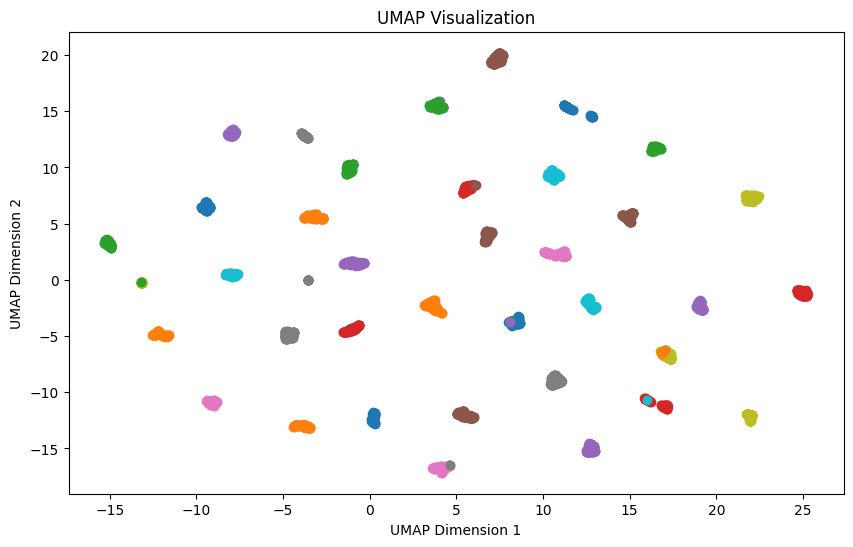

In [25]:
umap_result = umap.UMAP(n_components=2).fit_transform(df['vector'].tolist())
df['umap_x'] = umap_result[:, 0]
df['umap_y'] = umap_result[:, 1]

plt.figure(figsize=(10, 6))
categories = df['category_prompt'].unique()
for category in categories:
    indices = df['category_prompt'] == category
    plt.scatter(df.loc[indices, 'umap_x'], df.loc[indices, 'umap_y'], label=category)

plt.title('UMAP Visualization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## Clustering

In [26]:
df.head()

,category_prompt,text,vector,umap_x,umap_y
0,writers,Write about a character who wakes up in a diff...,"[0.53249586, 0.31645346, -0.94890106, 0.697275...",8.406798,-3.600737
1,writers,"Write a story that begins with the sentence, “...","[0.62360275, 0.27531216, -0.9430659, 0.5974340...",8.547602,-3.791947
2,writers,Write about a character who discovers they hav...,"[0.5743828, 0.25408795, -0.9473946, 0.697927, ...",8.420183,-3.719397
3,writers,Write a story from the perspective of an objec...,"[0.62613, 0.30668694, -0.9397523, 0.6973928, 0...",8.558508,-3.377014
4,writers,Write about a world where dreams become reality.,"[0.49779677, 0.36968523, -0.9467022, 0.5965820...",8.278400,-3.598037


In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score


# Step 1: Prepare the input data
X = df['vector'].tolist()
y = pd.Categorical(df['category_prompt']).codes  # Convert categories to numeric labels

### K-Means

In [28]:
num_categories = len(df['category_prompt'].unique())

# Step 2: Build the K-means model
kmeans_model = KMeans(n_clusters=num_categories)
kmeans_model.fit(X)
kmeans_clusters = kmeans_model.labels_

# Step 4: Evaluate the clustering results
kmeans_ari = adjusted_rand_score(y, kmeans_clusters)
kmeans_silhouette = silhouette_score(X, kmeans_clusters)

print(f"K-means ARI: {kmeans_ari:.4f}, Silhouette Score: {kmeans_silhouette:.4f}")

df['kmeans_labels'] = kmeans_clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-means ARI: 0.9773, Silhouette Score: 0.8299


In [29]:
number_to_category_kmeans = {}

for category in df['category_prompt'].unique():
  number_to_category_kmeans[df[df['category_prompt'] == category]['kmeans_labels'].value_counts().idxmax()] = category

df['kmeans_labels_categories'] = df['kmeans_labels'].apply(lambda x: number_to_category_kmeans[x])

In [30]:
Accuracy = df[df['category_prompt'] == df['kmeans_labels_categories']].shape[0] / df.shape[0]
print(f'Accuracy of Kmeans is {Accuracy:.4f}')

Accuracy of Kmeans is 0.9889


#### Save K-Means model

In [31]:
import pickle

# Save the K-means model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_model, f)

#### Load K-Means model

In [32]:
with open('kmeans_model.pkl', 'rb') as f:
    kmeans_model = pickle.load(f)

## Pipeline

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

class Pipeline:
  def __init__(self, number_to_category_kmeans, Bert_load_path='/content/bert_classifier.pt', kmeans_model_name='kmeans_model'):
    # Bert tokenzier
    self.tokenizer  = BertTokenizer.from_pretrained('bert-base-uncased')

    # Bert model
    self.Bert_load_path = Bert_load_path
    self.Bert_model = torch.load(Bert_load_path)
    self.Bert_model.eval()

    # K-means model
    with open(f'{kmeans_model_name}.pkl', 'rb') as f:
      self.kmeans_model = pickle.load(f)

    # number_to_category_kmeans
    self.number_to_category_kmeans = number_to_category_kmeans

    # DF
    self.df = df


  def tokenize_text(self, text):
      tokens = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=128,
          padding='max_length',
          truncation=True,
          return_tensors='pt')
      return tokens

  def get_bert_embeddings(self, text):
      inputs = self.tokenize_text(text)
      input_ids = inputs['input_ids'].to(device)
      attention_mask = inputs['attention_mask'].to(device)

      with torch.no_grad():
        outputs, pooled_output = self.Bert_model(input_ids, attention_mask, pooled=True)
        embedding = pooled_output.cpu().squeeze().numpy()
      return embedding

  def get_k_nearest_categories(self, vector, k):
    categories_sim = {}
    for i, center in enumerate(self.kmeans_model.cluster_centers_):
      categories_sim[self.number_to_category_kmeans[i]] = cosine_similarity(center.reshape(1, -1), vector.reshape(1, -1))[0][0]

    sorted_categories_sim = dict(sorted(categories_sim.items(), key=lambda item: item[1], reverse=True))
    largest_k_values = dict(list(sorted_categories_sim.items())[:k])

    return list(largest_k_values.keys())

  def get_k_best_prompts_from_k_categories(self, vector_text, categories_lst, k):
    big_df = pd.DataFrame(columns=['text', 'category_prompt'])

    for i, category in enumerate(categories_lst):
      lst_cosine = []
      df_category = self.df[self.df['category_prompt'] == category]
      for vector_prompt in df_category['vector']:
        cos = cosine_similarity(vector_text.reshape(1, -1), vector_prompt.reshape(1, -1))[0][0]
        lst_cosine.append(cos)

      df_category['cosine'] = lst_cosine
      df_category = df_category.sort_values('cosine', ascending=False).head(k)
      big_df = pd.concat([big_df, df_category[['text', 'category_prompt']]])

    return big_df

  def pipeline(self, text, k_categories, k_sample):
    embedding = self.get_bert_embeddings(text)
    categories_lst = self.get_k_nearest_categories(embedding, k_categories)
    last_df = self.get_k_best_prompts_from_k_categories(embedding, categories_lst, k_sample)
    return last_df

## Example

In [34]:
prompt_Pipeline = Pipeline(number_to_category_kmeans, Bert_load_path='/content/bert_classifier.pt', kmeans_model_name='kmeans_model')

In [35]:
example = df[df['category_prompt'] == 'Product-Managers'].iloc[1]
print(example.text)

“How can I identify the most profitable features to add to my product roadmap?”


In [49]:
prompt_Pipeline.pipeline(text=example.text, k_categories=3, k_sample=1)

<ipython-input-33-a3863d70d6e3>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category['cosine'] = lst_cosine
<ipython-input-33-a3863d70d6e3>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category['cosine'] = lst_cosine
<ipython-input-33-a3863d70d6e3>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,text,category_prompt
1014,“How can I identify the most profitable featur...,Product-Managers
1371,What strategies can you use to proactively pre...,Customer-Service
1943,Can you recommend any evidence-based intervent...,health-professionals


# Evaluation

In [37]:
prompts = {
    'writers': [
        "Create a story about a character who wakes up in a different body every day.",
        "Craft a narrative where the protagonist experiences a new body each morning.",
        "Write a story about someone who finds themselves in a different person's life every day.",
        "Develop a tale where the main character inhabits a new body with unique challenges daily.",
        "Imagine a scenario where the central character wakes up in a different identity every dawn."
    ],
    'developers': [
        "Write a tutorial on how to use Chat GPT to generate code snippets.",
        "Craft a guide explaining the process of generating code snippets using Chat GPT.",
        "Develop a step-by-step tutorial for utilizing Chat GPT in code snippet creation.",
        "Create a guide demonstrating the effective use of Chat GPT for producing code snippets.",
        "Compose a tutorial that teaches users how to harness Chat GPT's capabilities for code generation."
    ],
    'seo': [
        "Develop a comprehensive guide to technical SEO for travel content, including how to use schema markup and structured data.",
        "Write an in-depth manual on optimizing travel content with technical SEO, incorporating schema markup and structured data.",
        "Create a guide that covers technical SEO strategies tailored for the travel niche, focusing on schema markup and structured data.",
        "Craft an extensive guide to implementing schema markup and structured data in travel-related SEO.",
        "Provide a detailed overview of technical SEO techniques for travel content, with a focus on schema markup and structured data."
    ],
    'social-media': [
        "Help me identify my target audience on social media and suggest ways to reach them.",
        "Provide assistance with audience research on social media platforms and offer strategies to engage the target demographic.",
        "Craft a plan to discover the target audience on social media and propose methods to effectively connect with them.",
        "Give advice on conducting audience research on social media and provide strategies for reaching the intended audience.",
        "Develop a strategy to pinpoint the target audience on social media and recommend approaches to effectively engage them."
    ],
    'accountants': [
        "How can small business owners use accounting to track expenses and enhance profitability?",
        "Write about utilizing accounting techniques for expense tracking and profit optimization in small businesses.",
        "Craft a guide for small business owners on leveraging accounting practices to monitor expenses and boost profitability.",
        "Provide advice on how accounting methods can be employed by small business owners to effectively track expenses and increase profitability.",
        "Develop strategies for small business owners to utilize accounting tools in tracking expenses and maximizing profitability."
    ],
    'college-students': [
        "How can Chat GPT assist in finding credible sources for research papers?",
        "Write a guide on using Chat GPT to discover reliable sources for academic research papers.",
        "Develop strategies for college students to employ Chat GPT in locating credible sources for research papers.",
        "Provide advice on leveraging Chat GPT for identifying reputable sources for research papers as a college student.",
        "Craft a tutorial on effectively using Chat GPT to aid college students in finding trustworthy sources for research papers."
    ],
    'game-developers': [
        "What are best practices for game development to ensure a high-quality end product?",
        "Create a guide outlining essential game development practices for achieving a top-notch final product.",
        "Craft a comprehensive manual on game development best practices to ensure high-quality outcomes.",
        "Provide advice on implementing best practices in game development to achieve excellence in the final product.",
        "Develop strategies for game developers to follow best practices and achieve a high-quality end product."
    ],
    'programmers': [
        "Implement a text-based adventure game in Python where the player navigates through different rooms and solves puzzles.",
        "Create a text-based adventure game using Python, involving room navigation and puzzle-solving mechanics.",
        "Craft a Python program for a text-based adventure game with room navigation and interactive puzzle elements.",
        "Develop a text-based adventure game in Python, allowing players to explore rooms and engage with puzzle challenges.",
        "Write a program in Python to implement a text-based adventure game featuring room traversal and puzzle-solving."
    ],
    'Marketers': [
        "Generate 5 creative ideas for a guerrilla marketing campaign about a new product.",
        "Craft 5 unique guerrilla marketing campaign concepts for promoting a recently launched product.",
        "Develop a list of 5 creative and unconventional marketing ideas for a guerrilla campaign centered around a new offering.",
        "Provide 5 innovative and out-of-the-box ideas for executing a guerrilla marketing campaign to promote a product.",
        "Brainstorm 5 distinct guerrilla marketing strategies aimed at generating buzz for a new product."
    ],
    'Amazon-Sellers': [
        "How can I optimize my product listings on Amazon to enhance visibility and sales?",
        "Provide guidance on enhancing product listings on Amazon to increase visibility and drive sales.",
        "Craft a strategy for optimizing product listings on Amazon to improve visibility and boost sales performance.",
        "Develop a comprehensive plan for Amazon sellers to optimize product listings and achieve better visibility and sales results.",
        "Write a guide on strategies to effectively optimize Amazon product listings for improved visibility and sales success."
    ],
    'Product-Managers': [
        "What are the latest trends in product management, and how can they be leveraged effectively?",
        "Provide insights into the recent trends in product management and ways to harness them for optimal results.",
        "Craft a comprehensive overview of the latest trends in product management and strategies to make the most of them.",
        "Develop a guide on leveraging the latest trends in product management to enhance product performance and success.",
        "Write about the emerging trends in product management and techniques for incorporating them to achieve better outcomes."
    ],
    'Internet-Marketers': [
        "What are the top SEO strategies for small businesses?",
        "Provide an overview of the most effective SEO strategies tailored for small businesses.",
        "Craft a guide outlining the key SEO strategies that are particularly beneficial for small businesses.",
        "Develop a comprehensive list of SEO strategies best suited for small businesses seeking improved online visibility.",
        "Write about the top SEO techniques that can offer significant benefits to small businesses."
    ],
    'Business': [
        "What are emerging industries or markets that present untapped opportunities for businesses?",
        "Provide insights into industries or markets with untapped potential for business growth and innovation.",
        "Craft a guide highlighting emerging industries and markets that offer unexplored opportunities for businesses.",
        "Develop a comprehensive list of industries or markets that show promise for businesses looking to expand.",
        "Write about lesser-known industries and markets that have the potential to provide new avenues for business development."
    ],
    'Customer-Service': [
        "Create a template for an email response to customers inquiring about our return policy.",
        "Craft an email template to address customer inquiries about the company's return policy.",
        "Develop a sample email response that answers customer questions related to the return policy.",
        "Provide an email template for effectively communicating the company's return policy to customers.",
        "Write a sample email that can be used to respond to customer queries regarding the return policy."
    ],
    'Lawyers': [
        "What are the key legal principles that apply to intellectual property cases?",
        "Provide an overview of the fundamental legal principles relevant to cases involving intellectual property.",
        "Craft a guide outlining the core legal principles that come into play in intellectual property litigation.",
        "Develop a comprehensive list of key legal concepts that are significant in intellectual property cases.",
        "Write about the essential legal principles that are essential to consider in cases involving intellectual property."
    ],
    'IT-Professionals': [
        "How can I secure my company's network from cyberattacks?",
        "Provide advice on implementing network security measures to protect a company from cyber threats.",
        "Craft a guide outlining strategies for safeguarding a company's network against potential cyberattacks.",
        "Develop a comprehensive plan for IT professionals to enhance network security and defend against cyber threats.",
        "Write about effective network security practices that IT professionals can implement to prevent cyberattacks."
    ],
    'Web-Developers': [
        "What are the key principles of web development, and how can they be applied to build high-quality web applications?",
        "Provide insights into the foundational principles of web development and how they contribute to creating top-notch web applications.",
        "Craft a guide outlining the essential principles of web development and their role in building high-quality web applications.",
        "Develop a comprehensive overview of the key principles in web development and their significance in crafting robust web applications.",
        "Write about the fundamental principles that guide web development and their impact on creating high-quality web applications."
    ],
    'Engineers': [
        "How do civil engineers design and build infrastructure to withstand natural disasters?",
        "Provide an overview of the strategies civil engineers employ to design and construct disaster-resistant infrastructure.",
        "Craft a guide detailing the methods used by civil engineers to create infrastructure that can withstand natural calamities.",
        "Develop a comprehensive overview of how civil engineers approach the design and construction of disaster-resilient infrastructure.",
        "Write about the techniques civil engineers use to develop infrastructure that can endure natural disasters."
    ],
    'Architects': [
        "What are the latest trends in sustainable architecture?",
        "Provide insights into the current trends shaping the field of sustainable architecture.",
        "Craft a guide highlighting the emerging trends that are influencing sustainable architecture practices.",
        "Develop a comprehensive overview of the latest developments in the realm of sustainable architecture.",
        "Write about the contemporary trends that are driving innovation and evolution in sustainable architectural design."
    ],
    'health-professionals': [
        "What are the latest guidelines for diagnosing and treating diabetes?",
        "Provide an overview of the most recent guidelines for diagnosing and managing diabetes.",
        "Craft a guide summarizing the updated guidelines on diagnosing and treating diabetes.",
        "Develop a comprehensive overview of the current recommendations for diagnosing and treating diabetes.",
        "Write about the latest advancements in diabetes diagnosis and treatment and the guidelines that accompany them."
    ],
    'Teachers-Educators': [
        "Can you provide me with some ideas for teaching history to middle school students?",
        "Craft engaging teaching strategies for conveying history lessons to middle school students.",
        "Develop creative ideas and approaches to effectively teach history to students at the middle school level.",
        "Provide innovative methods for educators to make history lessons captivating and engaging for middle school students.",
        "Write about strategies that educators can use to create impactful history lessons tailored for middle school students."
    ],
    'Travel-Agents': [
        "Can you provide me with a list of recommended boutique hotels in Paris within a moderate budget?",
        "Craft a list of charming boutique hotels in Paris that offer a great experience within a reasonable budget.",
        "Develop a selection of recommended boutique hotels in Paris that provide quality accommodations at a moderate cost.",
        "Provide a curated list of boutique hotels in Paris that offer a balance between quality and affordability.",
        "Write about boutique hotels in Paris that offer a delightful stay without breaking the bank."
    ],
    'Graphic-Designers': [
        "Can you provide tips for creating visually striking compositions in graphic design?",
        "Craft advice for graphic designers on how to create visually captivating compositions in their work.",
        "Develop a set of tips and techniques that graphic designers can utilize to craft visually impactful designs.",
        "Provide guidance on crafting visually appealing compositions in graphic design projects.",
        "Write about strategies and methods that graphic designers can use to create visually stunning compositions."
    ],
    'Data-Scientists': [
        "Can you provide an overview of the key steps in the data science lifecycle?",
        "Craft a comprehensive overview of the essential stages in the data science lifecycle.",
        "Develop a guide outlining the key steps that constitute the data science lifecycle.",
        "Provide insights into the sequence of stages involved in the data science lifecycle.",
        "Write about the fundamental steps that data scientists follow in the process of data analysis and modeling."
    ],
    'journalists': [
        "Can you provide an overview of the current situation regarding climate change and its impacts?",
        "Craft a comprehensive overview of the present state of climate change and its consequences.",
        "Develop a guide summarizing the current situation of climate change and its effects on the environment.",
        "Provide insights into the ongoing developments in climate change and the resulting environmental impacts.",
        "Write about the contemporary status of climate change and the various environmental challenges it presents."
    ],
    'scientists': [
        "Can you provide an overview of the latest research and advancements in quantum physics?",
        "Craft a comprehensive summary of the recent research progress and breakthroughs in the field of quantum physics.",
        "Develop an overview of the latest discoveries and advancements that have occurred in quantum physics.",
        "Provide insights into the cutting-edge research and developments in the realm of quantum physics.",
        "Write about the recent scientific achievements and advancements within the field of quantum physics."
    ],
    'social-workers': [
        "What are some effective strategies for building trust and rapport with clients in social work?",
        "Provide insights into strategies that social workers can employ to establish trust and rapport with their clients.",
        "Craft a guide outlining effective approaches for social workers to build meaningful relationships with their clients.",
        "Develop a comprehensive overview of strategies that promote trust and rapport in social work interactions.",
        "Write about techniques that social workers can use to develop strong connections and trust with their clients."
    ],
    'Librarians': [
        "What are some strategies for promoting reading and literacy programs in the community?",
        "Provide advice on promoting reading initiatives and literacy programs within the local community.",
        "Craft a guide outlining strategies that librarians can implement to enhance reading and literacy initiatives in the community.",
        "Develop a comprehensive plan for librarians to encourage reading and literacy programs within the community.",
        "Write about effective strategies for librarians to engage the community in reading and literacy activities."
    ],
    'Politicians': [
        "What are effective strategies for assembling a strong and cohesive political campaign team?",
        "Craft a guide outlining strategies for politicians to build a united and effective campaign team.",
        "Provide insights into the key approaches that politicians can use to create a robust and harmonious campaign team.",
        "Develop a comprehensive plan for assembling a capable and cooperative political campaign team.",
        "Write about the techniques and tactics that politicians can employ to establish a powerful and unified campaign team."
    ],
    'Food-Service-Professionals': [
        "Can you suggest creative ideas for unique vegetarian/vegan appetizers?",
        "Craft innovative and distinctive ideas for vegetarian and vegan appetizers.",
        "Develop a selection of creative and original appetizer concepts tailored for vegetarians and vegans.",
        "Provide a variety of unique and imaginative appetizer ideas suitable for vegetarian and vegan diets.",
        "Write about inventive ways to prepare vegetarian and vegan appetizers that will impress diners."
    ],
    'Fitness-Trainers': [
        "What are some effective exercises for targeting the glutes and building lower body strength?",
        "Craft a guide outlining a range of exercises designed to work the glutes and enhance lower body strength.",
        "Provide insights into effective workout routines that focus on strengthening the glutes and lower body muscles.",
        "Develop a comprehensive list of exercises that fitness trainers can incorporate to effectively target the glutes.",
        "Write about a variety of exercises that fitness trainers can use to help clients build strong glutes and lower body muscles."
    ],
    'Sports-Analysts': [
        "What are the key performance indicators for evaluating a soccer player's effectiveness on the field?",
        "Provide insights into the essential performance metrics used to assess a soccer player's performance during matches.",
        "Craft a guide outlining the important performance indicators that analysts use to evaluate soccer players.",
        "Develop a comprehensive list of key metrics that sports analysts consider when assessing a soccer player's effectiveness.",
        "Write about the critical performance indicators that sports analysts rely on to gauge a soccer player's impact on the game."
    ],
    'Photographers-and-videographers': [
        "Can you suggest unique composition techniques for capturing stunning landscape photographs?",
        "Craft innovative composition techniques for photographers to capture breathtaking landscape photos.",
        "Develop a selection of creative and original composition approaches tailored for landscape photography.",
        "Provide a variety of unique and imaginative composition ideas that photographers can use for landscape shots.",
        "Write about inventive ways to compose landscape photographs that result in visually captivating images."
    ],
    'Event Planners': [
        "What are some unique and memorable theme ideas for corporate events?",
        "Provide a selection of creative and distinctive theme concepts for organizing memorable corporate events.",
        "Craft a guide outlining unique and innovative themes that can be used to create impactful corporate events.",
        "Develop a comprehensive list of theme ideas that event planners can utilize to make corporate events unforgettable.",
        "Write about inventive themes that event planners can implement to add a special touch to corporate gatherings."
    ],
    'Real-Estate-Agents': [
        "How can I effectively market and advertise properties to attract potential buyers?",
        "Craft a guide outlining strategies for real estate agents to effectively market and advertise properties to potential buyers.",
        "Provide insights into effective approaches for promoting properties and attracting potential buyers.",
        "Develop a comprehensive plan for real estate agents to create compelling marketing campaigns for properties.",
        "Write about techniques and tactics that real estate agents can use to showcase properties and entice potential buyers."
    ],
    'Psychologists-and-Therapists': [
        "What are some effective techniques for managing and reducing anxiety in patients?",
        "Craft a guide outlining techniques that psychologists and therapists can use to help patients manage and alleviate anxiety.",
        "Provide insights into effective therapeutic methods for addressing and mitigating anxiety in patients.",
        "Develop a comprehensive overview of techniques that psychologists and therapists can employ to assist patients with anxiety.",
        "Write about evidence-based approaches that psychologists and therapists can utilize to support patients dealing with anxiety."
    ]
}


In [38]:
data = []

# Iterate through each category and its user requests
for category, requests in prompts.items():
    for request in requests:
        data.append({'Category': category, 'User Request': request})

# Create a DataFrame from the data list
test_df = pd.DataFrame(data)

In [39]:
# Save the DataFrame to a CSV file
test_df.to_csv('user_requests.csv', index=False)

In [40]:
csv_file_path = 'user_requests.csv'
test_df = pd.read_csv(csv_file_path)
test_df.head()

,Category,User Request
0,writers,Create a story about a character who wakes up ...
1,writers,Craft a narrative where the protagonist experi...
2,writers,Write a story about someone who finds themselv...
3,writers,Develop a tale where the main character inhabi...
4,writers,Imagine a scenario where the central character...


In [53]:
%%capture

import numpy as np
# Define a function to apply the model to each user request
def apply_model(row, k_categories):
    user_request = row['User Request']
    result = prompt_Pipeline.pipeline(text=user_request, k_categories=k_categories, k_sample=1)
    best_match = result.iloc[np.argmax(result['category_prompt'] == row['Category'])]
    return best_match['text'], best_match['category_prompt']


In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

k_categories_lst = [1,2,3,4,5,6,7,8,9,10]
precision_lst = []
recall_lst = []
f1_lst = []

for k_categories in tqdm(k_categories_lst):
  model_results = test_df.apply(lambda row: apply_model(row,k_categories), axis=1)
  test_df[['Generated Text', 'Generated Category']] = pd.DataFrame(model_results.tolist(), index=test_df.index)

  precision = precision_score(test_df['Category'], test_df['Generated Category'], average='weighted')
  recall = recall_score(test_df['Category'], test_df['Generated Category'], average='weighted')
  f1 = f1_score(test_df['Category'], test_df['Generated Category'], average='weighted')

  precision_lst.append(round(precision, 3))
  recall_lst.append(round(recall, 3))
  f1_lst.append(round(f1, 3))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|█         | 1/10 [00:16<02:29, 16.65s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 2/10 [00:35<02:21, 17.70s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

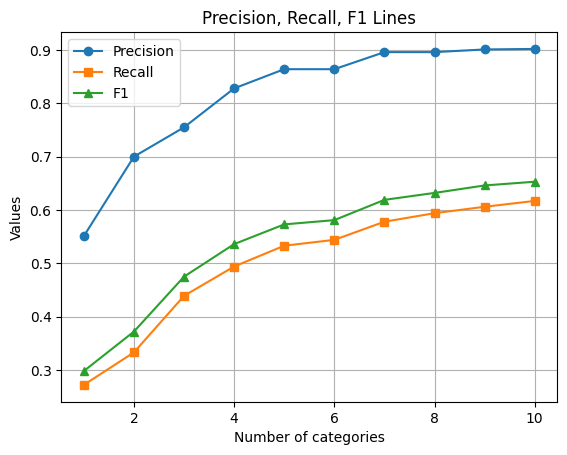

In [63]:
import matplotlib.pyplot as plt

# Plotting
plt.figure()
plt.plot(k_categories_lst, precision_lst, label='Precision', marker='o')
plt.plot(k_categories_lst, recall_lst, label='Recall', marker='s')
plt.plot(k_categories_lst, f1_lst, label='F1', marker='^')

plt.xlabel('Number of categories')
plt.ylabel('Values')
plt.title('Precision, Recall, F1 Lines')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
array(['writers', 'developers', 'seo', 'social-media', 'accountants',
       'college-students', 'game-developers', 'programmers', 'Marketers', 'Amazon-Sellers',
       'Product-Managers', 'Internet-Marketers', 'Business', 'Customer-Service', 'Lawyers',
       'IT-Professionals', 'Web-Developers', 'Engineers', 'Architects', 'health-professionals',
       'Teachers-Educators', 'Travel-Agents', 'Graphic-Designers', 'Data-Scientists', 'journalists',
       'scientists', 'social-workers', 'Librarians', 'Politicians', 'Food-Service-Professionals',
       'Fitness-Trainers', 'Sports-Analysts', 'Photographers-and-videographers', 'Event Planners', 'Real-Estate-Agents',
       'Psychologists-and-Therapists'] 36

